In [374]:
# Layoff Risk Prediction Project
# Dataset source: https://www.kaggle.com/datasets/swaptr/layoffs-2022/data

In [375]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [376]:
df = pd.read_csv('../Data/layoffs.csv')
df.head()

,company,location,total_laid_off,date,percentage_laid_off,industry,source,stage,funds_raised,country,date_added
0,Sonder,SF Bay Area,NaN,11/10/2025,1.00,Travel,https://skift.com/2025/11/10/sonder-shuts-down...,Post-IPO,839.0,United States,11/10/2025
1,Axonius,New York City,100.0,11/6/2025,0.11,Security,https://www.calcalistech.com/ctechnews/article...,Series E,865.0,United States,11/7/2025
2,MyBambu,Memphis,141.0,11/5/2025,1.00,Finance,https://cbs12.com/news/local/new-west-palm-bea...,Unknown,15.0,United States,11/7/2025
3,Hewlett Packard Enterprise,SF Bay Area,52.0,11/5/2025,NaN,Hardware,https://www.sfchronicle.com/tech/article/layof...,Post-IPO,1400.0,United States,11/7/2025
4,Indeed,Austin,NaN,11/5/2025,NaN,HR,https://www.businessinsider.com/indeed-layoffs...,Acquired,5.0,United States,11/8/2025


In [377]:
df.isna().sum()

company                   0
location                  1
total_laid_off         1459
date                      0
percentage_laid_off    1543
industry                  2
source                    3
stage                     5
funds_raised            475
country                   2
date_added                0
dtype: int64

In [378]:
df_clean = df.dropna().copy()
df_clean.head()

,company,location,total_laid_off,date,percentage_laid_off,industry,source,stage,funds_raised,country,date_added
1,Axonius,New York City,100.0,11/6/2025,0.11,Security,https://www.calcalistech.com/ctechnews/article...,Series E,865.0,United States,11/7/2025
2,MyBambu,Memphis,141.0,11/5/2025,1.00,Finance,https://cbs12.com/news/local/new-west-palm-bea...,Unknown,15.0,United States,11/7/2025
6,Porter,"Bengaluru, Non-U.S.",350.0,11/4/2025,0.18,Logistics,https://inc42.com/buzz/exclusive-porter-lays-o...,Series F,357.0,India,11/7/2025
7,Personio,"Munich, Non-U.S.",165.0,10/29/2025,0.10,HR,Internal memo,Series E,724.0,Germany,10/31/2025
8,Amazon,Seattle,14000.0,10/27/2025,0.01,Retail,https://www.cnbc.com/2025/10/28/amazon-layoffs...,Post-IPO,8100.0,United States,10/28/2025


In [379]:
df.isna().sum()

company                   0
location                  1
total_laid_off         1459
date                      0
percentage_laid_off    1543
industry                  2
source                    3
stage                     5
funds_raised            475
country                   2
date_added                0
dtype: int64

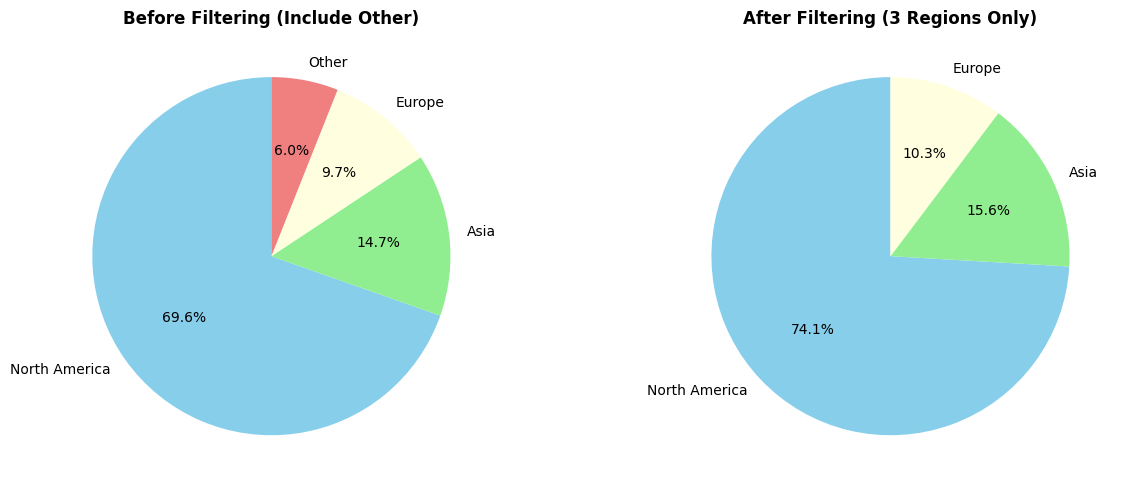

In [380]:
# Map raw country values into three major regions and remove minor regions
region_map = {
    # North America
    'United States': 'North America', 
    'Canada': 'North America', 
    'Mexico': 'North America',
    
    # Europe
    'United Kingdom': 'Europe', 'Germany': 'Europe', 'Sweden': 'Europe', 
    'Netherlands': 'Europe', 'France': 'Europe', 'Ireland': 'Europe', 
    'Estonia': 'Europe', 'Denmark': 'Europe', 'Norway': 'Europe', 
    'Austria': 'Europe', 'Spain': 'Europe', 'Czech Republic': 'Europe', 
    'Switzerland': 'Europe', 'Poland': 'Europe', 'Belgium': 'Europe', 
    'Luxembourg': 'Europe', 'Finland': 'Europe', 'Bulgaria': 'Europe', 
    'Russia': 'Europe',
    
    # Asia
    'India': 'Asia', 'Singapore': 'Asia', 'Israel': 'Asia', 'Indonesia': 'Asia',
    'Hong Kong': 'Asia', 'China': 'Asia', 'Japan': 'Asia', 'South Korea': 'Asia',
    'Malaysia': 'Asia', 'Thailand': 'Asia', 'UAE': 'Asia',
    'United Arab Emirates': 'Asia',
}

# Mapregions
df_temp = df_clean.copy()
df_temp['region'] = df_temp['country'].map(region_map).fillna('Other')

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Before
before_dist = df_temp['region'].value_counts()
colors_before = ['skyblue', 'lightgreen', 'lightyellow', 'lightcoral']
axes[0].pie(before_dist, labels=before_dist.index, autopct='%1.1f%%', 
            colors=colors_before, startangle=90)
axes[0].set_title('Before Filtering (Include Other)', fontsize=12, fontweight='bold')

# After
df_clean_filtered = df_temp[df_temp['region'].isin(['North America', 'Europe', 'Asia'])].copy()
after_dist = df_clean_filtered['region'].value_counts()
colors_after = ['skyblue', 'lightgreen', 'lightyellow']
axes[1].pie(after_dist, labels=after_dist.index, autopct='%1.1f%%', 
            colors=colors_after, startangle=90)
axes[1].set_title('After Filtering (3 Regions Only)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

df_clean = df_clean_filtered

In [381]:
# Aggregate company-level metrics from layoff events
df_company = df_clean.groupby('company').agg({
    'total_laid_off': 'sum',
    'percentage_laid_off': ['max', 'mean'],
    'date': ['min', 'max', 'count'],
    'industry': lambda x: x.mode()[0],
    'stage': lambda x: x.mode()[0],
    'funds_raised': 'first',
    'region': lambda x: x.mode()[0]
}).reset_index()

df_company.columns = ['company', 'total_laid_off_sum', 'max_percentage', 'avg_percentage', 'first_layoff', 'last_layoff', 'layoff_events_count', 'industry', 'stage', 'funds_raised', 'region']

In [382]:
# Engineer features and calculate normalized risk score
df_company['layoff_intensity'] = df_company['total_laid_off_sum'] / (df_company['layoff_events_count'] + 1)
df_company['years_active'] = (pd.to_datetime(df_company['last_layoff']) - pd.to_datetime(df_company['first_layoff'])).dt.days / 365

scaler = MinMaxScaler()
features_to_normalize = ['total_laid_off_sum', 'max_percentage', 'layoff_events_count', 'layoff_intensity']
normalized = scaler.fit_transform(df_company[features_to_normalize])
df_normalized = pd.DataFrame(normalized, columns=[f + '_norm' for f in features_to_normalize])
df_company = pd.concat([df_company, df_normalized], axis=1)

df_company['risk_score'] = (
    0.3 * df_company['total_laid_off_sum_norm'] +
    0.3 * df_company['max_percentage_norm'] +
    0.2 * df_company['layoff_events_count_norm'] +
    0.2 * df_company['layoff_intensity_norm']
)

df_company = df_company.sort_values('risk_score', ascending=False)

threshold = df_company['risk_score'].quantile(0.65)
df_company['high_risk'] = (df_company['risk_score'] >= threshold).astype(int)
df_company['recency'] = 2025 - pd.to_datetime(df_company['last_layoff']).dt.year

industry_avg_events = df_company.groupby('industry')['layoff_events_count'].transform('mean')
df_company['events_deviation'] = df_company['layoff_events_count'] - industry_avg_events

industry_avg_recency = df_company.groupby('industry')['recency'].transform('mean')
df_company['recency_deviation'] = df_company['recency'] - industry_avg_recency

df_final = df_company[['company', 'industry', 'stage', 'funds_raised', 'region', 'layoff_events_count', 'recency', 'events_deviation', 'recency_deviation', 'risk_score', 'high_risk']].copy()

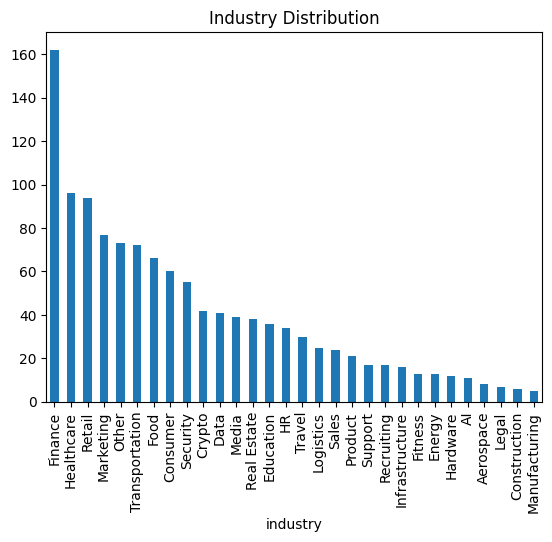

In [383]:
# Visualize industry distribution
df_company['industry'].value_counts().plot(kind='bar')
plt.title("Industry Distribution")
plt.show()

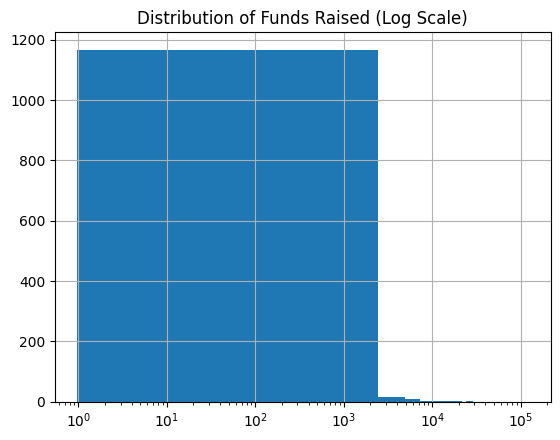

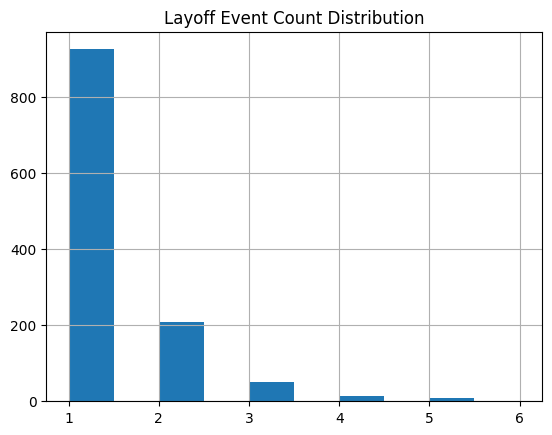

In [384]:
# Funds raised distribution (log scale)
df_company['funds_raised'].hist(bins=50)
plt.xscale('log')
plt.title("Distribution of Funds Raised (Log Scale)")
plt.show()

# Layoff event count distribution
df_company['layoff_events_count'].hist()
plt.title("Layoff Event Count Distribution")
plt.show()

In [385]:
# The original distribution of funds_raised is extremely right-skewed with heavy-tailed outliers.
# Similarly, layoff_events_count also shows a discrete, non-linear relationship with risk.

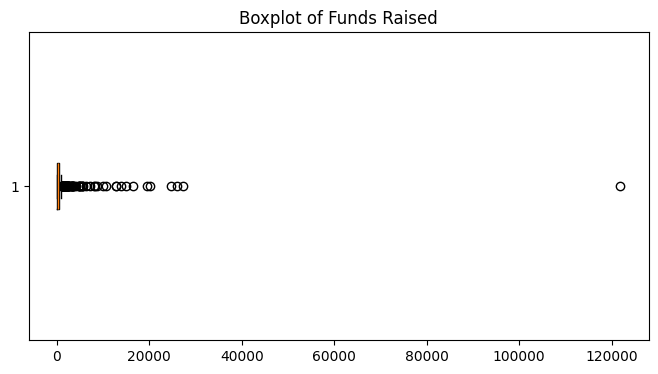

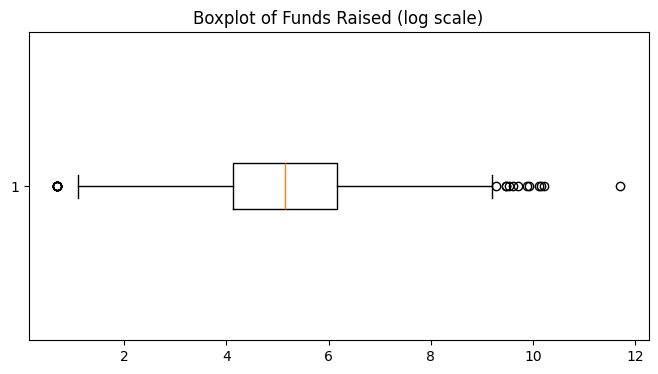

In [386]:
# Boxplot of funds raised
plt.figure(figsize=(8,4))
plt.boxplot(df_company['funds_raised'], vert=False)
plt.title("Boxplot of Funds Raised")
plt.show()

# Boxplot of funds raised (log scale)
plt.figure(figsize=(8,4))
plt.boxplot(np.log1p(df_company['funds_raised']), vert=False)
plt.title("Boxplot of Funds Raised (log scale)")
plt.show()

In [387]:
print("Top 10 Companies by Funds Raised:")
top_10 = df_company.nlargest(10, 'funds_raised')[['company', 'industry', 'region', 'funds_raised']]
display(top_10)

Top 10 Companies by Funds Raised:


,company,industry,region,funds_raised
695,Netflix,Media,North America,121900.0
1168,Xerox,Hardware,North America,27200.0
657,Meta,Consumer,North America,26000.0
1087,Uber,Transportation,North America,24700.0
1022,Tesla,Transportation,North America,20200.0
1143,WeWork,Real Estate,Asia,19500.0
443,Grab,Transportation,Asia,16500.0
264,Cruise,Transportation,North America,15000.0
710,Northvolt,Energy,Europe,13800.0
1083,Twitter,Consumer,North America,12900.0


In [388]:
df_company = df_company[df_company['company'] != 'Netflix']

In [389]:
# Compute original means used during deviation calculation
industry_avg_events = df_company.groupby('industry')['layoff_events_count'].mean()
industry_avg_recency = df_company.groupby('industry')['recency'].mean()

# Save using SAME column names that app.py expects
industry_avg = pd.DataFrame({
    'events_deviation': industry_avg_events,   
    'recency_deviation': industry_avg_recency    
})

joblib.dump(industry_avg, '../Model/industry_averages.pkl')
print("Industry averages saved!")
print(industry_avg)

Industry averages saved!
                events_deviation  recency_deviation
industry                                           
AI                      1.090909           0.636364
Aerospace               1.125000           2.375000
Construction            1.500000           4.000000
Consumer                1.383333           2.483333
Crypto                  1.261905           2.285714
Data                    1.219512           2.951220
Education               1.527778           2.861111
Energy                  1.230769           1.692308
Finance                 1.290123           3.006173
Fitness                 1.307692           3.769231
Food                    1.378788           2.909091
HR                      1.205882           3.235294
Hardware                1.166667           1.333333
Healthcare              1.260417           2.593750
Infrastructure          1.437500           3.187500
Legal                   1.142857           2.571429
Logistics               1.200000       

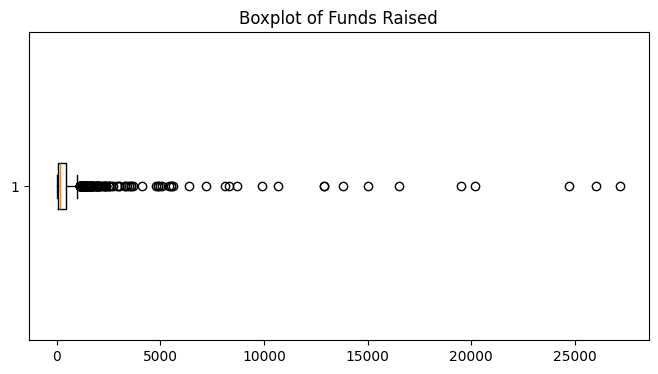

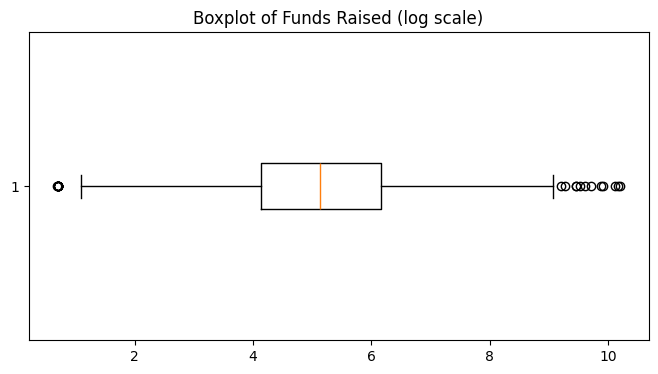

In [390]:
# Boxplot of funds raised
plt.figure(figsize=(8,4))
plt.boxplot(df_company['funds_raised'], vert=False)
plt.title("Boxplot of Funds Raised")
plt.show()
# Boxplot of funds raised (log scale)
plt.figure(figsize=(8,4))
plt.boxplot(np.log1p(df_company['funds_raised']), vert=False)
plt.title("Boxplot of Funds Raised (log scale)")
plt.show()

In [391]:
#Calculate the proportion by quartiles
q25 = df_final['funds_raised'].quantile(0.25)
q50 = df_final['funds_raised'].quantile(0.50)
q75 = df_final['funds_raised'].quantile(0.75)
print(f"Quartile Values:")
print(f"Q1 (25%): {q25}")
print(f"Q2 (50%): {q50}")
print(f"Q3 (75%): {q75}")

print(f"\nDistribution by Quartiles:")
tiny = (df_final['funds_raised'] < q25).sum()
small = ((df_final['funds_raised'] >= q25) & (df_final['funds_raised'] < q50)).sum()
medium = ((df_final['funds_raised'] >= q50) & (df_final['funds_raised'] < q75)).sum()
large = (df_final['funds_raised'] >= q75).sum()
print(f"tiny (< {q25}): {tiny} ({tiny/len(df_final)*100:.1f}%)")
print(f"small ({q25}-{q50}): {small} ({small/len(df_final)*100:.1f}%)")
print(f"medium ({q50}-{q75}): {medium} ({medium/len(df_final)*100:.1f}%)")
print(f"large (>= {q75}): {large} ({large/len(df_final)*100:.1f}%)")

Quartile Values:
Q1 (25%): 61.0
Q2 (50%): 169.5
Q3 (75%): 471.5

Distribution by Quartiles:
tiny (< 61.0): 298 (24.6%)
small (61.0-169.5): 307 (25.4%)
medium (169.5-471.5): 302 (25.0%)
large (>= 471.5): 303 (25.0%)


In [392]:
# Bin layoff event frequency
def bin_layoff_events(x):
    if x == 1:
        return "once"
    elif x == 2:
        return "twice"
    elif x == 3:
        return "thrice"
    else:
        return "four_plus"

df_final['layoff_events_category'] = df_final['layoff_events_count'].apply(bin_layoff_events)

In [393]:
# Bin funding amounts (using quartiles)
q25 = df_final['funds_raised'].quantile(0.25)
q50 = df_final['funds_raised'].quantile(0.50)
q75 = df_final['funds_raised'].quantile(0.75)

bins = [0, q25, q50, q75, float('inf')]
labels = ['tiny', 'small', 'medium', 'large']
df_final['funds_raised_binned'] = pd.cut(df_final['funds_raised'], bins=bins, labels=labels, include_lowest=True)

In [394]:
# Train-test split and save datasets
X = df_final[['company', 'industry', 'stage', 'funds_raised', 'region', 'recency', 'events_deviation', 'recency_deviation', 'layoff_events_category', 'funds_raised_binned']]
y = df_final['high_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.to_csv('../Data/X_train.csv', index=False)
X_test.to_csv('../Data/X_test.csv', index=False)
y_train.to_csv('../Data/y_train.csv', index=False)
y_test.to_csv('../Data/y_test.csv', index=False)
print("DATA PREPROCESSING COMPLETE")
print(f"Total samples: {len(df_final)}")
print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features: {list(X_train.columns)}")

DATA PREPROCESSING COMPLETE
Total samples: 1210
Train set: (968, 10)
Test set: (242, 10)
Features: ['company', 'industry', 'stage', 'funds_raised', 'region', 'recency', 'events_deviation', 'recency_deviation', 'layoff_events_category', 'funds_raised_binned']


In [395]:
print("\nTraining set preview (first 10 rows):")
display(X_train.head(10).style.set_properties(**{'text-align': 'center'}).background_gradient())


Training set preview (first 10 rows):


,company,industry,stage,funds_raised,region,recency,events_deviation,recency_deviation,layoff_events_category,funds_raised_binned
176,Calibrate,Healthcare,Series B,127.000000,North America,3,-0.260417,0.406250,once,small
1113,Veho,Logistics,Series B,299.000000,North America,1,-0.200000,-2.000000,once,medium
1205,iFit,Fitness,Private Equity,200.000000,North America,3,-0.307692,-0.769231,once,medium
135,Boost,Finance,Series B,37.000000,North America,2,-0.290123,-1.006173,once,tiny
848,Redesign Health,Healthcare,Series C,315.000000,North America,3,-0.260417,0.406250,once,medium
1060,TravelTriangle,Travel,Series D,47.000000,Asia,5,-0.433333,1.300000,once,tiny
454,Grubhub,Food,Acquired,284.000000,North America,2,0.621212,-0.909091,twice,medium
1100,Unity,Other,Post-IPO,1300.000000,North America,3,3.630137,0.931507,four_plus,large
118,Bitwise,Crypto,Series B,84.000000,North America,2,-0.261905,-0.285714,once,small
115,BitTitan,Data,Acquired,46.000000,North America,4,-0.219512,1.048780,once,tiny
